In [1]:
import joblib
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

# Carregando os datasets

Abaixo observa-se que ambos os datasets `ind_df` e `conn_df` possuem missing values. Em particular, chama a atenção o fato de que em `conn_df` os missing values concentram-se na variável target, a probabilidade de contaminação.

## conn_df

In [87]:
conn_df = pd.read_csv('../data/raw/conexoes_espec.csv', sep=';')

In [88]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [89]:
conn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   V1           999999 non-null  int64  
 1   V2           999999 non-null  int64  
 2   grau         999999 non-null  object 
 3   proximidade  999999 non-null  object 
 4   prob_V1_V2   499999 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 38.1+ MB


In [90]:
conn_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
V1,999999.0,NaN,NaN,NaN,250000.25,144337.495129,1.0,125000.5,250000.0,375000.0,500000.0
V2,999999.0,NaN,NaN,NaN,500001.0,288674.990255,2.0,250001.5,500001.0,750000.5,1000000.0
grau,999999,3,trabalho,333548,NaN,NaN,NaN,NaN,NaN,NaN,NaN
proximidade,999999,4,visita_rara,400238,NaN,NaN,NaN,NaN,NaN,NaN,NaN
prob_V1_V2,499999.0,NaN,NaN,NaN,0.485162,0.173963,0.074462,0.351677,0.486413,0.61821,0.942245


In [91]:
conn_df['grau'].unique()

array(['trabalho', 'amigos', 'familia'], dtype=object)

In [92]:
conn_df['proximidade'].unique()

array(['visita_frequente', 'visita_rara', 'visita_casual', 'mora_junto'],
      dtype=object)

## ind_df

In [8]:
ind_df = pd.read_csv('../data/raw/individuos_espec.csv', sep=';')

In [9]:
ind_df

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [10]:
ind_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   name                       1000000 non-null  int64  
 1   idade                      904063 non-null   float64
 2   estado_civil               949927 non-null   object 
 3   qt_filhos                  971133 non-null   float64
 4   estuda                     959870 non-null   float64
 5   trabalha                   993647 non-null   float64
 6   pratica_esportes           850876 non-null   float64
 7   transporte_mais_utilizado  956967 non-null   object 
 8   IMC                        886130 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 68.7+ MB


In [11]:
ind_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name,1000000.0,NaN,NaN,NaN,500000.5,288675.278933,1.0,250000.75,500000.5,750000.25,1000000.0
idade,904063.0,NaN,NaN,NaN,30.008431,10.951566,0.0,22.0,29.0,37.0,124.0
estado_civil,949927,4,solteiro,420637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qt_filhos,971133.0,NaN,NaN,NaN,0.928406,0.997289,0.0,0.0,1.0,1.0,9.0
estuda,959870.0,NaN,NaN,NaN,0.442588,0.496693,0.0,0.0,0.0,1.0,1.0
trabalha,993647.0,NaN,NaN,NaN,0.556739,0.496771,0.0,0.0,1.0,1.0,1.0
pratica_esportes,850876.0,NaN,NaN,NaN,0.599823,0.489934,0.0,0.0,1.0,1.0,1.0
transporte_mais_utilizado,956967,3,publico,574779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMC,886130.0,NaN,NaN,NaN,22.472079,7.073692,4.852828,17.420851,21.4312,26.378197,89.158204


In [12]:
ind_df['estado_civil'].unique()

array(['divorciado', 'casado', 'solteiro', nan, 'viuvo'], dtype=object)

In [13]:
ind_df['transporte_mais_utilizado'].unique()

array(['publico', 'particular', 'taxi', nan], dtype=object)

## Combinando ind_df e conn_df

In [14]:
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V2'),
                  conn_df, 
                  how='right',
                  left_on='name_V2', 
                  right_on='V2')
df_raw = pd.merge(ind_df.rename(columns=lambda x: x + '_V1'),
                  df_raw, 
                  how='right',
                  left_on='name_V1', 
                  right_on='V1')
df_raw = df_raw.drop(['V1', 'V2'], axis=1)
df_raw

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,NaN,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,NaN,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


# Utils

Modelos de classificação do scikit-learn não aceitam probabilidade como variável target, portanto a estratégia adotada para treinar modelos e estimar as probabilidades de contaminação foi:
1. aplicar a transformação logit (inversa da função sigmoide) às probabilidades, a fim de que possam assumir qualquer valor real;
2. treinar modelos de regressão utilizando os logits das probabilidades;
3. aplicar a transformação sigmoide aos resultados obtidos, e assim recuperar o target em termos de probabilidades; e
4. comparar a performance dos modelos usando a função de perda cross-entropy.

In [15]:
def logit(p):
    return np.log(p / (1-p))

def sigmoid(y):
    ey = np.exp(y)
    return ey / (1+ey)

def cross_entropy_loss(y_true, y_pred):
    p, q = sigmoid(y_true), sigmoid(y_pred)
    return -(p*np.log(q) + (1-p)*np.log(1-q)).mean()

# Modelos

In [16]:
categorical_cols = ['estado_civil_V1', 'estado_civil_V2',
                    'transporte_mais_utilizado_V1', 'transporte_mais_utilizado_V2',
                    'grau', 'proximidade']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

numerical_cols = ['idade_V1', 'qt_filhos_V1', 'IMC_V1',
                  'idade_V2', 'qt_filhos_V2', 'IMC_V2']

cols_to_drop = ['name_V1', 'name_V2', 'prob_V1_V2']

## Modelo Baseline

A fim de se obter rapidamente um modelo baseline cuja performance servirá como benchmark para os demais modelos, os missing values foram imputados da forma mais básica possível, de acordo com as seguintes estratégias:
1. variáveis categóricas $\leftarrow$ moda
2. variáveis booleanas $\leftarrow$ média
3. variáveis numéricas $\leftarrow$ mediana.

Para os demais modelos, foram testadas diferentes estratégias para imputar os missing values em `ind_df`. Já no caso de `conn_df`, foi utilizada sempre a mesma estratégia de imputar os missing values com as predições do modelo KNN Regressor (aplicado a uma versão do dataset original com a dimensionalidade reduzida pelo método PCA, buscando preservar cerca de 90% da variância explicada pelas features originais), treinado em um dataset com dados completos. Por fim, o target foi, em todos os casos, estimado utilizando-se a Regressão Linear a fim de que a comparabilidade das estratégias de imputação fosse preservada.


A única exceção a estas regras foi o último modelo, LightGBM Regressor, por se tratar de um que a presença de missing values entre os dados não representa um problema.

In [17]:
df_bl = df_raw.copy(deep=True)

df_bl['prob_V1_V2'].fillna(df_bl['prob_V1_V2'].median(skipna=True), inplace=True)

In [18]:
X_bl = df_bl.drop(cols_to_drop, axis=1)
y_bl = df_bl['prob_V1_V2']

X_bl_train_, X_bl_test_, y_bl_train, y_bl_test = train_test_split(X_bl,
                                                                  logit(y_bl),
                                                                  test_size=0.4,
                                                                  random_state=42)

In [19]:
X_bl_train, X_bl_test = X_bl_train_.copy(deep=True), X_bl_test_.copy(deep=True)

mode_imp = SimpleImputer(strategy='most_frequent')
mean_imp = SimpleImputer(strategy='mean')
median_imp = SimpleImputer(strategy='median')

X_bl_train[categorical_cols] = mode_imp.fit_transform(X_bl_train_[categorical_cols])
X_bl_train[boolean_cols] = mean_imp.fit_transform(X_bl_train_[boolean_cols])
X_bl_train[numerical_cols] = median_imp.fit_transform(X_bl_train_[numerical_cols])

X_bl_test[categorical_cols] = mode_imp.transform(X_bl_test_[categorical_cols])
X_bl_test[boolean_cols] = mean_imp.transform(X_bl_test_[boolean_cols])
X_bl_test[numerical_cols] = median_imp.transform(X_bl_test_[numerical_cols])

In [20]:
one_enc = OneHotEncoder(drop='first', sparse=False)
one_enc.fit(X_bl_train[categorical_cols])

one_hot_cols = one_enc.get_feature_names(categorical_cols)

X_bl_train[one_hot_cols] = one_enc.transform(X_bl_train[categorical_cols])
X_bl_train.drop(categorical_cols, axis=1, inplace=True)

X_bl_test[one_hot_cols] = one_enc.transform(X_bl_test[categorical_cols])
X_bl_test.drop(categorical_cols, axis=1, inplace=True)

In [21]:
bl_model = LinearRegression().fit(X_bl_train, y_bl_train)

In [22]:
train_loss = cross_entropy_loss(y_bl_train, bl_model.predict(X_bl_train))
test_loss = cross_entropy_loss(y_bl_test, bl_model.predict(X_bl_test))

print('baseline train loss:', train_loss)
print('baseline test loss:', test_loss)

baseline train loss: 0.684272325646911
baseline test loss: 0.6842074405738243


## Modelo 1

A imputação dos missing values em `ind_df` foi feita utilizando o KNNImputer, um método computacionalmente bastante custoso. Em se tratando de um dataset com 1M de linhas, este processo teve uma duração média de 8 horas e 30 minutos. Por outro lado, a imputação do target em `conn_df` foi bem rápida, uma vez que a dimensionalidade do dataset foi reduzida de 31 features para 15 após aplicação do PCA.

In [23]:
ind_df_1 = ind_df.copy(deep=True)

In [24]:
ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [25]:
cat_to_values = {'divorciado': 0,
                 'casado': 1,
                 'solteiro': 2,
                 'viuvo': 3,
                 'publico': 4,
                 'particular': 5,
                 'taxi': 6}

ind_df_1_ = ind_df_1.replace(cat_to_values)

scaler = MinMaxScaler()
ind_df_1_ = scaler.fit_transform(ind_df_1_.drop('name', axis=1))

In [26]:
# %%time

# knn_imp = KNNImputer(weights='distance')

# ind_df_1_ = knn_imp.fit_transform(ind_df_1_)

In [27]:
# ind_df_1_ = pd.DataFrame(scaler.inverse_transform(ind_df_1_), columns=ind_df_1_.columns)
# ind_df_1 = pd.concat([ind_df_1['name'], ind_df_1_], axis=1)

In [28]:
# cols = ['estado_civil', 'transporte_mais_utilizado']
# values_to_cat = {v: k for (k, v) in cat_to_values.items()}
# ind_df_1[cols] = ind_df_1[cols].round().replace(values_to_cat)

In [29]:
ind_df_1 = pd.read_csv('../data/processed/ind_df_filled_knn.csv')

ind_df_1

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,16.856449
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [30]:
conn_df

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN
...,...,...,...,...,...
999994,499998,999996,trabalho,visita_rara,NaN
999995,499998,999997,trabalho,visita_rara,NaN
999996,499999,999998,familia,visita_casual,0.451662
999997,499999,999999,familia,visita_rara,0.186973


In [31]:
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_1 = pd.merge(ind_df_1.rename(columns=lambda x: x + '_V1'),
                df_1, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_1 = df_1.drop(['V1', 'V2'], axis=1)
df_1

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,casado,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,16.856449,familia,visita_casual,0.451662
999997,499999,26.0,casado,3.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [32]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_1_ = pd.get_dummies(df_1.drop(cols_to_drop, axis=1), drop_first=True)
df_1_ = pca.fit_transform(scaler.fit_transform(df_1_))
pca_comps = [f'pc_{n+1}' for n in range(df_1_.shape[1])]
df_1_ = pd.DataFrame(scaler.fit_transform(df_1_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.086315
pc_2     0.168872
pc_3     0.247949
pc_4     0.326829
pc_5     0.387379
pc_6     0.447829
pc_7     0.508215
pc_8     0.568447
pc_9     0.625686
pc_10    0.679968
pc_11    0.734119
pc_12    0.787714
pc_13    0.841276
pc_14    0.872330
pc_15    0.903357
dtype: float64

In [33]:
df_1_ = df_1_.loc[:, :pca_comps[-1]]
df_1_['prob_V1_V2'] = df_1['prob_V1_V2']

df_1_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,prob_V1_V2
0,0.653480,0.978062,0.498888,0.586829,0.450084,0.124045,0.413572,0.698691,0.992547,0.208060,0.341915,0.117494,0.213687,0.194833,0.364329,0.589462
1,0.015578,0.983627,0.331448,0.392191,0.146284,0.229305,0.702338,0.583029,0.249563,0.186896,0.332452,0.085130,0.219747,0.284321,0.222317,0.708465
2,0.982948,0.980343,0.498266,0.597786,0.428147,0.337495,0.255632,0.597697,0.046075,0.940550,0.395555,0.861075,0.120225,0.511721,0.570669,NaN
3,0.008505,0.987550,0.229662,0.292308,0.465730,0.342809,0.249001,0.643342,0.223280,0.678965,0.265058,0.062450,0.171574,0.594902,0.440663,0.638842
4,0.566265,0.496067,0.786290,0.520869,0.687914,0.477644,0.366519,0.255958,0.400936,0.686252,0.179619,0.839795,0.160781,0.381837,0.469448,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.021601,0.974196,0.599403,0.710349,0.385815,0.312614,0.235336,0.407990,0.216311,0.283496,0.780356,0.178889,0.834128,0.521004,0.559124,NaN
999995,0.020955,0.974755,0.601013,0.708428,0.155606,0.479019,0.512950,0.431922,0.216957,0.279284,0.781477,0.155176,0.841583,0.520748,0.557757,NaN
999996,0.987836,0.013022,0.578336,0.683063,0.897644,0.434051,0.499722,0.576376,0.064234,0.463309,0.131524,0.044837,0.936712,0.726113,0.236927,0.451662
999997,0.018214,0.013243,0.501543,0.594012,0.822749,0.397972,0.495630,0.446773,0.215903,0.965429,0.496460,0.090819,0.802927,0.513344,0.568878,0.186973


In [34]:
df_1_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.487136,0.408548,0.000000,0.021075,0.571158,0.974656,1.000000
pc_2,999999.0,0.499554,0.395057,0.000000,0.021109,0.499193,0.978008,1.000000
pc_3,999999.0,0.499670,0.204613,0.000000,0.353328,0.500663,0.635035,1.000000
pc_4,999999.0,0.489310,0.205700,0.000000,0.328125,0.499037,0.626108,1.000000
pc_5,999999.0,0.467670,0.213161,0.000000,0.305529,0.464711,0.619285,1.000000
pc_6,999999.0,0.487157,0.170445,0.000000,0.364730,0.486413,0.605837,1.000000
pc_7,999999.0,0.395239,0.203290,0.000000,0.248246,0.396399,0.533261,1.000000
pc_8,999999.0,0.466763,0.174713,0.000000,0.341857,0.468248,0.593560,1.000000
pc_9,999999.0,0.328804,0.327034,0.000000,0.060367,0.213232,0.413298,1.000000
pc_10,999999.0,0.491858,0.215099,0.000000,0.300925,0.490406,0.673899,1.000000


In [35]:
mask = df_1_['prob_V1_V2'].isna()
X_1_isna = df_1_.loc[mask].drop('prob_V1_V2', axis=1)
X_1_notna = df_1_.loc[~mask].drop('prob_V1_V2', axis=1)
y_1_notna = logit(df_1_.loc[~mask, 'prob_V1_V2'])

In [36]:
knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

knn_reg_imp.fit(X_1_notna, y_1_notna)

df_1_.loc[mask, 'prob_V1_V2'] = sigmoid(knn_reg_imp.predict(X_1_isna))

In [37]:
df_1['prob_V1_V2'] = df_1_['prob_V1_V2']

X_1_, y_1 = df_1.drop(cols_to_drop, axis=1), df_1['prob_V1_V2']
X_1 = pd.get_dummies(X_1_, drop_first=True)

In [38]:
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1,
                                                            logit(y_1),
                                                            test_size=0.4,
                                                            random_state=42)

In [39]:
lr_1_model = LinearRegression().fit(X_1_train, y_1_train)

In [40]:
train_loss = cross_entropy_loss(y_1_train, lr_1_model.predict(X_1_train))
test_loss = cross_entropy_loss(y_1_test, lr_1_model.predict(X_1_test))

print('lr_1 train loss:', train_loss)
print('lr_1 test loss:', test_loss)

lr_1 train loss: 0.6579712179892695
lr_1 test loss: 0.6580647215588603


## Modelo 2

Observamos uma melhora significativa na performance do Modelo 1 em relação ao do Baseline, no entanto a um custo de mais de 8 horas de treinamento. Para a imputação dos missing values em `ind_df` no Modelo 2, tentamos então realizá-la utilizando EDA, e tentando encontrar padrões e correspondências entre os dados.

In [41]:
ind_df_2 = ind_df.copy(deep=True)

In [42]:
ind_df_2

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
...,...,...,...,...,...,...,...,...,...
999995,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771
999996,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402
999997,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,NaN
999998,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569


In [43]:
ind_df_2.isna().mean().sort_values()

name                         0.000000
trabalha                     0.006353
qt_filhos                    0.028867
estuda                       0.040130
transporte_mais_utilizado    0.043033
estado_civil                 0.050073
idade                        0.095937
IMC                          0.113870
pratica_esportes             0.149124
dtype: float64

In [44]:
ind_df_2.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,-0.001,0.001,-0.000,0.001
idade,-0.001,1.000,0.116,-0.139,0.137,0.001,-0.000
qt_filhos,0.000,0.116,1.000,-0.080,0.079,-0.001,-0.000
estuda,-0.001,-0.139,-0.080,1.000,-0.096,-0.000,0.000
trabalha,0.001,0.137,0.079,-0.096,1.000,0.001,-0.001
pratica_esportes,-0.000,0.001,-0.001,-0.000,0.001,1.000,-0.001
IMC,0.001,-0.000,-0.000,0.000,-0.001,-0.001,1.000


Uma observação interessante acima é a correlação praticamente nula entre as variáveis `pratica_esportes`, `IMC` e as demais.

In [45]:
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.171049
3.0    0.057057
4.0    0.014179
5.0    0.002797
6.0    0.000490
7.0    0.000055
8.0    0.000009
9.0    0.000001
Name: qt_filhos, dtype: float64

Por conta do baixo volume de observações com `qt_filhos > 1`, adotei como estratégia bucketizar todas essas observações. Assim, o número de categorias em `qt_filhos` caiu para 3, mas cada uma com um volume representativo de observações.

In [46]:
ind_df_2.loc[ind_df_2['qt_filhos'] > 1, 'qt_filhos'] = 2
ind_df_2['qt_filhos'].value_counts(normalize=True)

0.0    0.413333
1.0    0.341031
2.0    0.245637
Name: qt_filhos, dtype: float64

In [47]:
ind_df_2['estuda'].value_counts(normalize=True)

0.0    0.557412
1.0    0.442588
Name: estuda, dtype: float64

In [48]:
ind_df_2['trabalha'].value_counts(normalize=True)

1.0    0.556739
0.0    0.443261
Name: trabalha, dtype: float64

### EDA

#### `qt_filhos`, `estuda` e `trabalha`

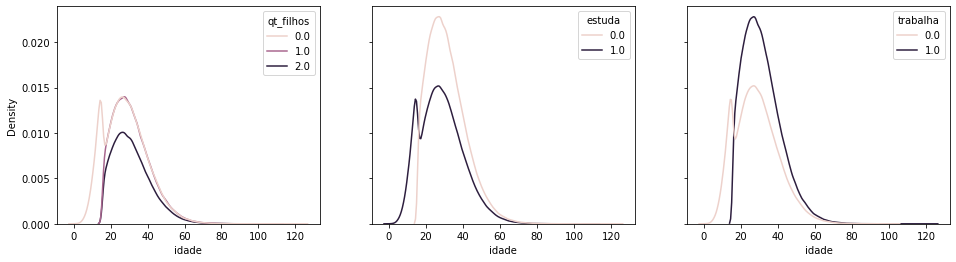

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.kdeplot(x='idade', hue='qt_filhos', data=ind_df_2, ax=ax[0])
sns.kdeplot(x='idade', hue='estuda', data=ind_df_2, ax=ax[1])
sns.kdeplot(x='idade', hue='trabalha', data=ind_df_2, ax=ax[2]);

Nos gráficos acima, vemos um padrão peculiar quando a idade é cerca de 16 anos, que pode ser explicado pelo fato de pessoas com 16 anos ou menos tendem a não ter filhos, estudarem e não trabalharem. Por conta disso, resolvi segmentar `idade` em um número suficiente de quantis que pudesse isolar este grupo de pessoas com menos de 16 anos. Como veremos abaixo, este segmento de pessoas, de fato, apresenta um comportamento diferente dos demais no que diz respeito às variáveis `qt_filhos`, `estuda` e `trabalha`. E, curiosamente, pessoas com 16 anos ou mais apresentam, em média, perfis de comportamento praticamente idênticos em relação a estas mesmas variáveis.

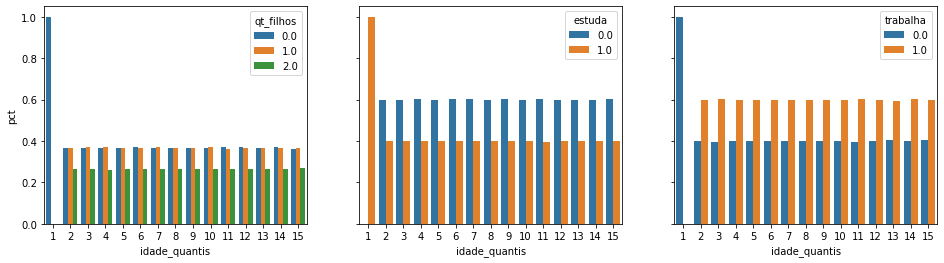

In [50]:
ind_df_2['idade_quantis'] = pd.qcut(ind_df_2['idade'], q=15, labels=range(1, 16))

filhos_df = (ind_df_2
             .groupby('idade_quantis')['qt_filhos']
             .value_counts(normalize=True)
             .rename('pct')
             .reset_index())
estuda_df = (ind_df_2
             .groupby('idade_quantis')['estuda']
             .value_counts(normalize=True)
             .rename('pct')
             .reset_index())
trabalha_df = (ind_df_2
               .groupby('idade_quantis')['trabalha']
               .value_counts(normalize=True)
               .rename('pct')
               .reset_index())

fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
sns.barplot(x='idade_quantis', y='pct', hue='qt_filhos', data=filhos_df, ax=ax[0])
sns.barplot(x='idade_quantis', y='pct', hue='estuda', data=estuda_df, ax=ax[1])
ax[1].set_ylabel('')
sns.barplot(x='idade_quantis', y='pct', hue='trabalha', data=trabalha_df, ax=ax[2])
ax[2].set_ylabel('');

In [51]:
ind_df_2.loc[ind_df_2['idade_quantis'] == 1, 'idade'].describe().T

count    64535.000000
mean        12.455629
std          2.397361
min          0.000000
25%         11.000000
50%         13.000000
75%         14.000000
max         15.000000
Name: idade, dtype: float64

In [52]:
ind_df_2_ = ind_df_2.query('idade_quantis > 1').copy(deep=True)

In [53]:
ind_df_2_.corr().round(3)

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
name,1.000,-0.001,0.000,0.000,-0.000,-0.000,0.001
idade,-0.001,1.000,0.001,-0.001,-0.001,0.000,0.000
qt_filhos,0.000,0.001,1.000,0.000,-0.001,-0.001,-0.000
estuda,0.000,-0.001,0.000,1.000,-0.000,0.000,-0.000
trabalha,-0.000,-0.001,-0.001,-0.000,1.000,0.001,0.000
pratica_esportes,-0.000,0.000,-0.001,0.000,0.001,1.000,-0.002
IMC,0.001,0.000,-0.000,-0.000,0.000,-0.002,1.000


Uma observação interessante acima é a correlação praticamente nula entre todas as variáveis, uma vez que consideramos apenas pessoas com 16 anos ou mais. E como veremos abaixo, o mesmo fenômeno ocorre em relação às variáveis categóricas `estado_civil` e `transporte_mais_utilizado`.

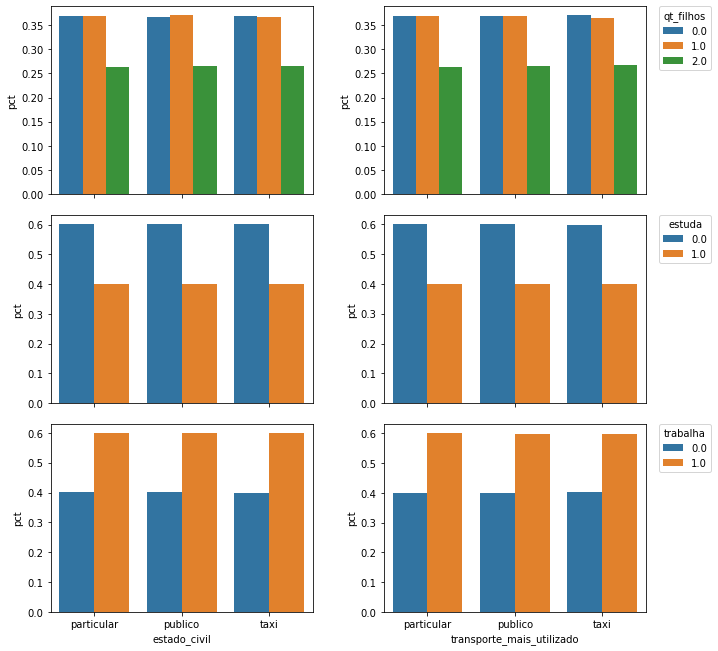

In [54]:
fig, ax = plt.subplots(3, 2, figsize=(9, 9), sharex=True)
fig.tight_layout(w_pad=4)

cols_1 = ['qt_filhos', 'estuda', 'trabalha']
cols_2 = ['estado_civil', 'transporte_mais_utilizado']
for i, c1 in enumerate(cols_1):
    for j, c2 in enumerate(cols_2):
        tmp = (ind_df_2_
               .groupby(c2)[c1]
               .value_counts(normalize=True)
               .rename('pct')
               .reset_index())
        sns.barplot(x=c2, y='pct', hue=c1, data=tmp, ax=ax[i%3, j%2])
        if (c1 == 'qt_filhos') or (c1 == 'estuda'):
            ax[i%3, j%2].set_xlabel('')
        if c2 == 'estado_civil':
            ax[i%3, j%2].get_legend().remove()
        if c2 == 'transporte_mais_utilizado':
            ax[i%3, j%2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, title=c1)

Abaixo imputamos os missing values em `qt_filhos`, `estuda` e `trabalha` de acordo com as seguintes regras:
1. `idade < 16` $\leftarrow$ 0;
2. caso contrário $\leftarrow$ valor esperado das observações em que `idade > 15`;
3. no caso especial da variável `trabalha`, temos ainda uma informação adicional vinda da variável `grau` em `conn_df` que nos permite imputar com certeza missing values de observações em que `grau = trabalho`.

In [55]:
cols = ['qt_filhos', 'estuda', 'trabalha']
for c in cols:
    pct_df = ind_df_2_[c].value_counts(normalize=True)
    mask_1, mask_2 = ind_df_2[c].isna(), ind_df_2['idade_quantis'] == 1
    if c == 'qt_estuda':
        ind_df_2.loc[mask_1 & mask_2, c] = 0
    elif c == 'estuda':
        ind_df_2.loc[mask_1 & mask_2, c] = 1
    else:
        names = np.append(conn_df.loc[conn_df['grau'] == 'trabalho', 'V1'].unique(),
                          conn_df.loc[conn_df['grau'] == 'trabalho', 'V2'].unique())
        ind_df_2.loc[mask_1 & ind_df_2.index.isin(names), c] = 1
        ind_df_2.loc[mask_1 & mask_2, c] = 0
    ind_df_2[c].fillna(sum(pct_df.index*pct_df.values), inplace=True)

#### `transporte_mais_utilizado`

In [56]:
ind_df_2_['IMC_quantis'] = pd.qcut(ind_df_2_['IMC'], q=10, labels=range(1, 11))

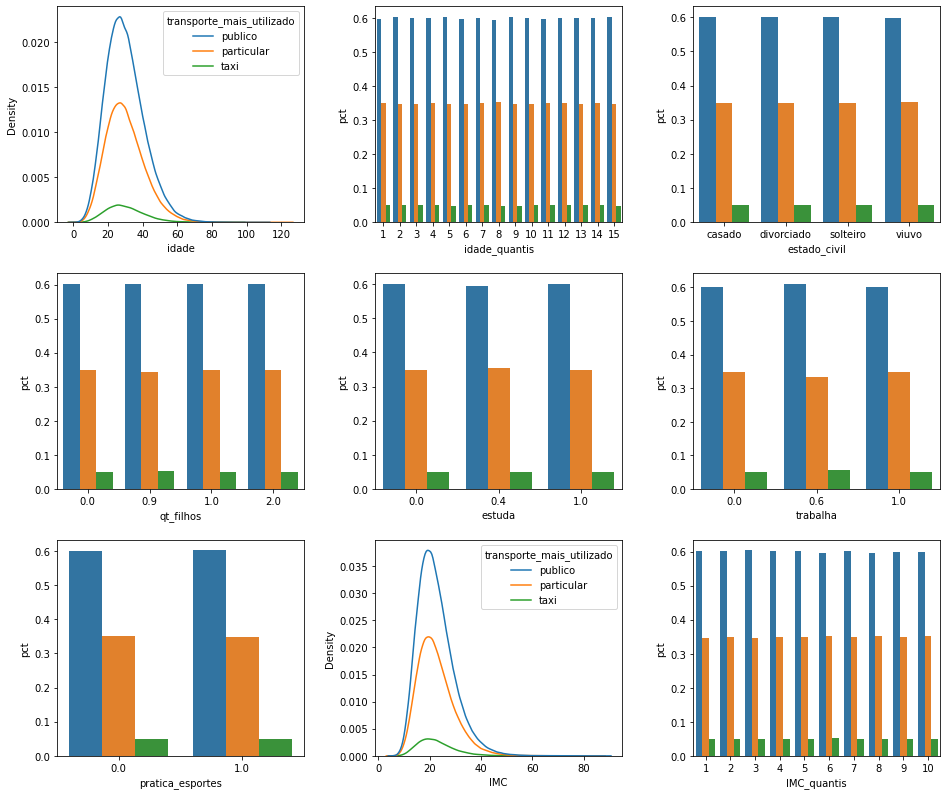

In [57]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

sns.kdeplot(x='idade', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_quantis', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'pratica_esportes']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['transporte_mais_utilizado']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['transporte_mais_utilizado']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='transporte_mais_utilizado', data=ind_df_2, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='transporte_mais_utilizado', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

Como vemos acima, as demais variáveis não nos dão pistas de uma boa forma de imputar missing values em `transporte utilizado`. Portanto, dado o volume significativo de missing values nesta variável, equivalente à categoria `taxi`, eu optei por criar uma nova categoria apelidada de `outros` pra preencher estes valores.

In [58]:
transp_pct_df = ind_df_2['transporte_mais_utilizado'].value_counts(normalize=True)
transp_pct_df

publico       0.600626
particular    0.349111
taxi          0.050263
Name: transporte_mais_utilizado, dtype: float64

In [59]:
ind_df_2['transporte_mais_utilizado'].fillna('outros', inplace=True)

#### `estado_civil`

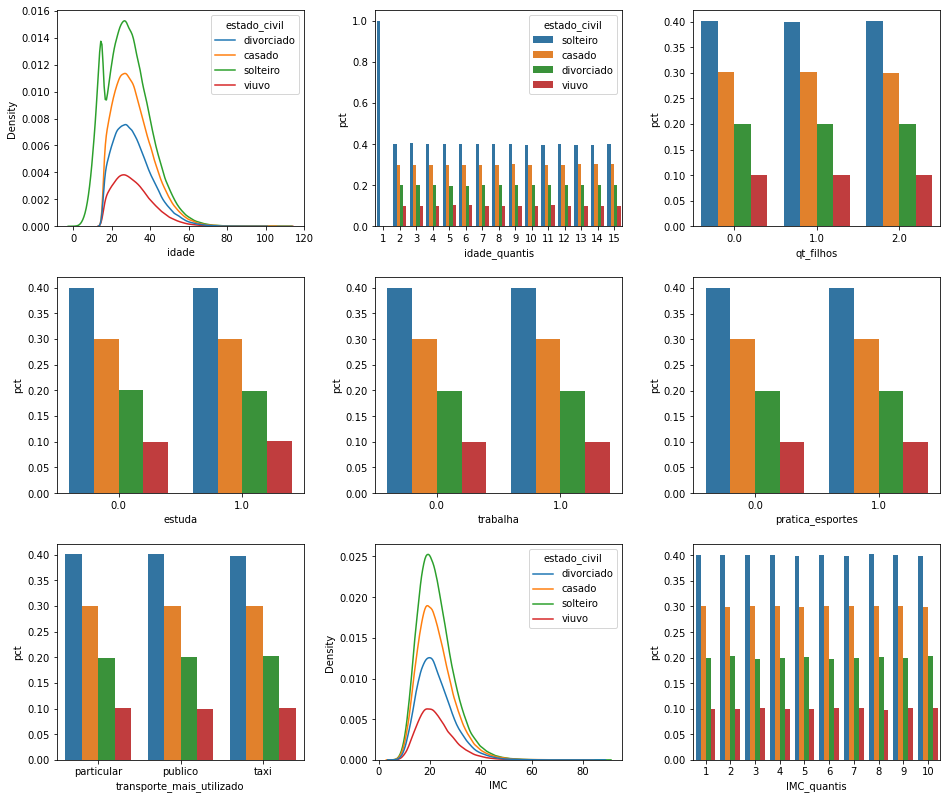

In [60]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

tmp = (ind_df_2
       .groupby('idade_quantis')['estado_civil']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())

sns.kdeplot(x='idade', hue='estado_civil', data=ind_df_2, ax=ax[0, 0])
sns.barplot(x='idade_quantis', y='pct', hue='estado_civil', data=tmp, ax=ax[0, 1])

cols = ['qt_filhos', 'estuda', 'trabalha', 'pratica_esportes', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=2):
    tmp = (ind_df_2_
           .groupby(c)['estado_civil']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='estado_civil', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['estado_civil']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='estado_civil', data=ind_df_2_, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='estado_civil', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

Aqui, notamos fenômemo similar ao observado em `qt_filhos`, `estuda` e `trabalha`, no qual pessoas com menos de 16 anos são mais propensas a terem `estado_civil = solteiro`. E mais uma vez, considerando apenas observações com `idade` superior ou igual a 16 anos, observamos a ausência de correlação entre esta e as demais variáveis. Nesses casos, assim como já foi feito anteriormente, os missing values foram imputados com uma nova categoria apelidada de `outros`, dado o volume significativo destes.

In [61]:
estcv_pct_df = ind_df_2_['estado_civil'].value_counts(normalize=True)
estcv_pct_df

solteiro      0.399955
casado        0.300265
divorciado    0.199779
viuvo         0.100001
Name: estado_civil, dtype: float64

In [62]:
mask = ind_df_2['estado_civil'].isna()
ind_df_2.loc[mask & (ind_df_2['idade_quantis'] == 1), 'estado_civil'] = 'solteiro'
ind_df_2['estado_civil'].fillna('outros', inplace=True)

#### `pratica_esportes`

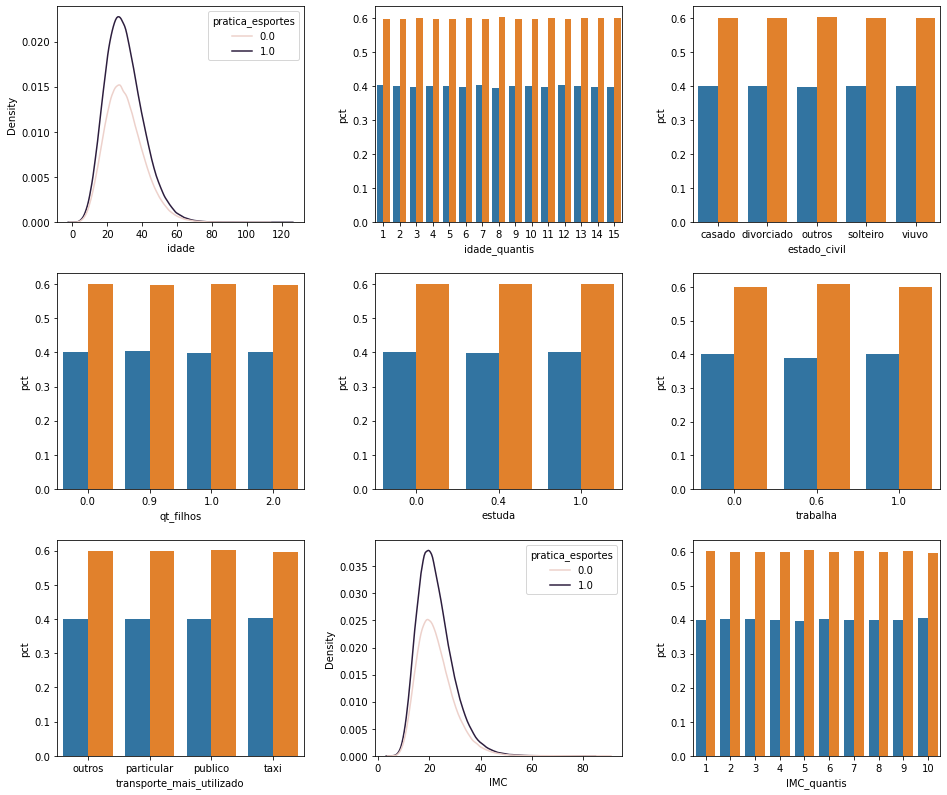

In [63]:
fig, ax = plt.subplots(3, 3, figsize=(13, 11))
fig.tight_layout(h_pad=3, w_pad=4)

sns.kdeplot(x='idade', hue='pratica_esportes', data=ind_df_2, ax=ax[0, 0])

cols = ['idade_quantis', 'estado_civil', 'qt_filhos', 'estuda', 'trabalha', 'transporte_mais_utilizado']
for n, c in enumerate(cols, start=1):
    tmp = (ind_df_2
           .groupby(c)['pratica_esportes']
           .value_counts(normalize=True)
           .rename('pct')
           .reset_index())
    g = sns.barplot(x=c, y='pct', hue='pratica_esportes', data=tmp, ax=ax[n//3, n%3])
    if c in ['qt_filhos', 'estuda', 'trabalha']:
        g.set_xticklabels(labels=['{:.1f}'.format(x) for x in tmp[c].unique()])
    ax[n//3, n%3].get_legend().remove()

tmp = (ind_df_2_
       .groupby('IMC_quantis')['pratica_esportes']
       .value_counts(normalize=True)
       .rename('pct')
       .reset_index())
sns.kdeplot(x='IMC', hue='pratica_esportes', data=ind_df_2, ax=ax[2, 1])
sns.barplot(x='IMC_quantis', y='pct', hue='pratica_esportes', data=tmp, ax=ax[2, 2])
ax[2, 2].get_legend().remove();

Caso similar ao de `tranporte_utilizado`, e com missing values imputados utilizando-se o valor esperado da variável.

In [64]:
esportes_pct_df = ind_df_2_['pratica_esportes'].value_counts(normalize=True)
esportes_pct_df

1.0    0.600067
0.0    0.399933
Name: pratica_esportes, dtype: float64

In [65]:
mask = ind_df_2['pratica_esportes'].isna()
ind_df_2['pratica_esportes'].fillna(sum(esportes_pct_df.index*esportes_pct_df.values), inplace=True)

#### `IMC` e `idade`

Para estas variáveis numéricas e contínuas, a estratégia de imputação utilizada foi pela mediana.

In [66]:
ind_df_2['IMC'].fillna(ind_df_2['IMC'].median(skipna=True), inplace=True)
ind_df_2['idade'].fillna(ind_df_2['idade'].median(skipna=True), inplace=True)

ind_df_2.drop('idade_quantis', axis=1, inplace=True)

### Treinamento

Uma vez com `ind_df` completo, o combinamos com `conn_df` e procedemos com a redução da dimensionalidade com o método PCA, reduzindo o número de features, agora, de 31 para 18, seguido da imputação dos missing values no target com o KNN Regressor, como discutido anteriormente. Desta vez, no entanto, diferentemente do que ocorreu com o Modelo 1, o processo de imputação nesta segunda etapa levou cerca de 2 horas e 30 minutos. Ainda asssim, mesmo considerando o tempo gasto com toda a parte de EDA para completar `ind_df`, a estratégia de imputação utilizada no Modelo 2 teve uma duração total consideravelmente menor que aquela utilizada no Modelo 1, e como veremos abaixo, obtendo ainda uma taxa de performance apenas ligeiramente inferior.

In [67]:
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V2'),
                conn_df, 
                how='right',
                left_on='name_V2', 
                right_on='V2')
df_2 = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V1'),
                df_2, 
                how='right',
                left_on='name_V1', 
                right_on='V1')
df_2 = df_2.drop(['V1', 'V2'], axis=1)
df_2

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,NaN
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,outros,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999996,...,casado,1.0,0.0,1.0,1.0,publico,17.556771,trabalho,visita_rara,NaN
999995,499998,23.0,casado,0.0,1.0,1.0,0.0,publico,22.036885,999997,...,casado,1.0,0.0,1.0,1.0,particular,24.848402,trabalho,visita_rara,NaN
999996,499999,26.0,casado,2.0,0.0,0.0,0.0,taxi,19.543889,999998,...,divorciado,1.0,0.0,0.0,1.0,publico,21.431200,familia,visita_casual,0.451662
999997,499999,26.0,casado,2.0,0.0,0.0,0.0,taxi,19.543889,999999,...,casado,0.0,1.0,1.0,1.0,publico,16.979569,familia,visita_rara,0.186973


In [68]:
scaler = MinMaxScaler()
pca = PCA(n_components=0.9, random_state=42)

df_2_ = pd.get_dummies(df_2.drop(cols_to_drop, axis=1), drop_first=True)
df_2_ = pca.fit_transform(scaler.fit_transform(df_2_))
pca_comps = [f'pc_{n+1}' for n in range(df_2_.shape[1])]
df_2_ = pd.DataFrame(scaler.fit_transform(df_2_), columns=pca_comps)

pd.Series(pca.explained_variance_ratio_, index=pca_comps).cumsum()

pc_1     0.088533
pc_2     0.176837
pc_3     0.249184
pc_4     0.318381
pc_5     0.384968
pc_6     0.451393
pc_7     0.501474
pc_8     0.551408
pc_9     0.599383
pc_10    0.644588
pc_11    0.689653
pc_12    0.732036
pc_13    0.774379
pc_14    0.804979
pc_15    0.835530
pc_16    0.861741
pc_17    0.887889
pc_18    0.910927
dtype: float64

In [69]:
df_2_ = df_2_.loc[:, :pca_comps[-1]]
df_2_['prob_V1_V2'] = df_2['prob_V1_V2']

df_2_

,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,pc_10,pc_11,pc_12,pc_13,pc_14,pc_15,pc_16,pc_17,pc_18,prob_V1_V2
0,0.427964,0.006026,0.649753,0.021943,0.509623,0.540523,0.770561,0.720674,0.990898,0.233959,0.347784,0.378561,0.031285,0.229370,0.584022,0.202639,0.367944,0.046757,0.589462
1,0.009622,0.574803,0.015365,0.016329,0.620537,0.371899,0.876619,0.552474,0.261018,0.200993,0.319780,0.374571,0.031264,0.545905,0.523040,0.320083,0.224481,0.043199,0.708465
2,0.424330,0.006445,0.979089,0.022235,0.482354,0.572972,0.587223,0.554399,0.058849,0.938425,0.485759,0.982188,0.366393,0.464838,0.221503,0.524010,0.605311,0.036116,NaN
3,0.427646,0.006822,0.008666,0.014400,0.674374,0.273162,0.579233,0.575731,0.230615,0.706516,0.285386,0.383088,0.013020,0.853626,0.143928,0.637057,0.468911,0.028104,0.638842
4,0.989754,0.427822,0.567964,0.512217,0.228088,0.585520,0.457132,0.319389,0.403388,0.703565,0.218929,0.970943,0.371846,0.452868,0.550595,0.346677,0.530764,0.978212,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,0.429487,0.005973,0.020558,0.028412,0.406574,0.699967,0.591894,0.373879,0.221594,0.253935,0.720292,0.033290,0.625576,0.383856,0.246333,0.530582,0.598511,0.035527,NaN
999995,0.010832,0.574792,0.020294,0.027201,0.408627,0.702455,0.592021,0.374266,0.221106,0.252644,0.720157,0.030486,0.625679,0.384297,0.245149,0.530719,0.597731,0.034565,NaN
999996,0.727876,0.227328,0.986255,0.980299,0.484948,0.687318,0.487519,0.709374,0.085866,0.502065,0.070721,0.008821,0.613114,0.506984,0.810158,0.733454,0.278397,0.026896,0.451662
999997,0.726648,0.228629,0.018964,0.979553,0.551933,0.580607,0.551660,0.549646,0.226815,0.961302,0.492865,0.032423,0.596604,0.292196,0.853497,0.473920,0.593005,0.031283,0.186973


In [70]:
df_2_.describe().T

,count,mean,std,min,25%,50%,75%,max
pc_1,999999.0,0.482541,0.325982,0.000000,0.298266,0.426421,0.723271,1.000000
pc_2,999999.0,0.383911,0.326342,0.000000,0.007617,0.424997,0.575514,1.000000
pc_3,999999.0,0.486635,0.407434,0.000000,0.021820,0.570445,0.972962,1.000000
pc_4,999999.0,0.499251,0.389572,0.000000,0.028045,0.499577,0.970491,1.000000
pc_5,999999.0,0.499919,0.194403,0.000000,0.362538,0.508957,0.641970,1.000000
pc_6,999999.0,0.496119,0.195516,0.000000,0.356571,0.503952,0.641832,1.000000
pc_7,999999.0,0.484323,0.179216,0.000000,0.356382,0.489005,0.610710,1.000000
pc_8,999999.0,0.452462,0.178449,0.000000,0.328034,0.454891,0.578380,1.000000
pc_9,999999.0,0.331678,0.319565,0.000000,0.075716,0.219569,0.414823,1.000000
pc_10,999999.0,0.496513,0.212387,0.000000,0.306471,0.495993,0.682331,1.000000


In [71]:
mask = df_2_['prob_V1_V2'].isna()
X_2_isna = df_2_.loc[mask].drop('prob_V1_V2', axis=1)
X_2_notna = df_2_.loc[~mask].drop('prob_V1_V2', axis=1)
y_2_notna = logit(df_2_.loc[~mask, 'prob_V1_V2'])

In [72]:
# %%time

# knn_reg_imp = KNeighborsRegressor(weights='distance', n_jobs=-1)

# knn_reg_imp.fit(X_2_notna, y_2_notna)

# df_2_.loc[mask, 'prob_V1_V2'] = sigmoid(knn_reg_imp.predict(X_2_isna))

In [73]:
# df_2['prob_V1_V2'] = df_2_['prob_V1_V2']
df_2['prob_V1_V2'] = pd.read_csv('../data/processed/df_2_prob_V1_V2_filled_knn.csv')

X_2_, y_2 = df_2.drop(cols_to_drop, axis=1), df_2['prob_V1_V2']
X_2 = pd.get_dummies(X_2_, drop_first=True)

In [74]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2,
                                                            logit(y_2),
                                                            test_size=0.4,
                                                            random_state=42)

lr_2_model = LinearRegression().fit(X_2_train, y_2_train)

In [75]:
train_loss = cross_entropy_loss(y_2_train, lr_2_model.predict(X_2_train))
test_loss = cross_entropy_loss(y_2_test, lr_2_model.predict(X_2_test))

print('lr_2 train loss:', train_loss)
print('lr_2 test loss:', test_loss)

lr_2 train loss: 0.6588959305935647
lr_2 test loss: 0.6589755849937751


## LightGBM Regressor

Esta estratégia, dentre todas as utilizadas, é certamente a mais eficiente, pois não há necessidade de se preocupar em imputar os missing values. E mais do que isso, é um modelo que utiliza o fato de que existem missing values como informação para o treinamento e otimização da performance. Entretanto, trata-se de um modelo altamente complexo e de difícil interpretação.

In [76]:
df_3 = pd.get_dummies(df_raw.drop(['name_V1', 'name_V2'], axis=1), drop_first=True)
X_3, y_3 = df_3.drop('prob_V1_V2', axis=1), df_3['prob_V1_V2']
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3,
                                                            logit(y_3),
                                                            test_size=0.4,
                                                            random_state=42)

In [77]:
lgbm_reg = lgb.LGBMRegressor(random_state=42)
lgbm_reg.fit(X_3_train, y_3_train);

In [78]:
train_loss = cross_entropy_loss(y_3_train, lgbm_reg.predict(X_3_train))
test_loss = cross_entropy_loss(y_3_test, lgbm_reg.predict(X_3_test))

print('lgbr train loss:', train_loss)
print('lgbr test loss:', test_loss)

lgbr train loss: 0.6489607855872174
lgbr test loss: 0.6490465650369334


# Estimando a taxa de contaminação para o resto da população

Feitas todas as considerações acima, optamos pela utilização do Modelo 2 por se tratar do melhor meio-termo quando ponderados os fatores: interpretabilidade, custo de modelagem e performance.

In [110]:
df_half = df_2.copy(deep=True)

In [102]:
rev_cols = ['V2', 'V1', 'grau', 'proximidade']
rev_conn_df = conn_df[rev_cols].copy(deep=True).rename(columns={'V1': 'V2', 'V2': 'V1'})
rev_conn_df['prob_V1_V2'] = np.nan

In [104]:
df_other_half = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V2'),
                         rev_conn_df, 
                         how='right',
                         left_on='name_V2', 
                         right_on='V2')
df_other_half = pd.merge(ind_df_2.rename(columns=lambda x: x + '_V1'),
                         df_other_half, 
                         how='right',
                         left_on='name_V1', 
                         right_on='V1')
df_other_half = df_other_half.drop(['V1', 'V2'], axis=1)

df_other_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,1,...,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,trabalho,visita_frequente,NaN
1,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,1,...,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,trabalho,visita_rara,NaN
2,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_casual,NaN
3,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_rara,NaN
4,6,20.0,outros,1.0,0.0,1.0,0.0,publico,20.412942,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,amigos,mora_junto,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,NaN
999995,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,NaN
999996,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,21.431200,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_casual,NaN
999997,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_rara,NaN


In [106]:
X_other_half_ = df_other_half.drop(cols_to_drop, axis=1)
X_other_half = pd.get_dummies(X_other_half_, drop_first=True)

In [107]:
# lr_model = joblib.load('../data/processed/lr_2_model.pkl')
lr_model = lr_2_model

In [108]:
df_other_half['prob_V1_V2'] = sigmoid(lr_model.predict(X_other_half))

In [109]:
df_other_half

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,1,...,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,trabalho,visita_frequente,0.641358
1,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,1,...,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,trabalho,visita_rara,0.511229
2,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_casual,0.488907
3,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_rara,0.565678
4,6,20.0,outros,1.0,0.0,1.0,0.0,publico,20.412942,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,amigos,mora_junto,0.344499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999994,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,0.459984
999995,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,0.437135
999996,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,21.431200,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_casual,0.688571
999997,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_rara,0.424986


In [111]:
df = df_half.append(df_other_half, ignore_index=True)

df

,name_V1,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,pratica_esportes_V1,transporte_mais_utilizado_V1,IMC_V1,name_V2,...,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2,grau,proximidade,prob_V1_V2
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,2,...,casado,0.0,0.0,0.0,1.0,publico,25.378720,trabalho,visita_frequente,0.589462
1,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956,3,...,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,trabalho,visita_rara,0.708465
2,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,4,...,casado,1.0,1.0,1.0,0.0,publico,26.732053,trabalho,visita_casual,0.639391
3,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720,5,...,solteiro,2.0,1.0,0.0,1.0,publico,15.295668,trabalho,visita_rara,0.638842
4,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393,6,...,outros,1.0,0.0,1.0,0.0,publico,20.412942,amigos,mora_junto,0.331446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999993,999996,34.0,casado,1.0,0.0,1.0,1.0,publico,17.556771,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,0.459984
1999994,999997,40.0,casado,1.0,0.0,1.0,1.0,particular,24.848402,499998,...,casado,0.0,1.0,1.0,0.0,publico,22.036885,trabalho,visita_rara,0.437135
1999995,999998,30.0,divorciado,1.0,0.0,0.0,1.0,publico,21.431200,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_casual,0.688571
1999996,999999,33.0,casado,0.0,1.0,1.0,1.0,publico,16.979569,499999,...,casado,2.0,0.0,0.0,0.0,taxi,19.543889,familia,visita_rara,0.424986


In [113]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
name_V1,1999998.0,NaN,NaN,NaN,375000.625,260208.29497,1.0,166667.25,333334.0,500000.75,1000000.0
idade_V1,1999998.0,NaN,NaN,NaN,29.912404,10.418753,0.0,23.0,29.0,36.0,124.0
estado_civil_V1,1999998,5,solteiro,847956,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qt_filhos_V1,1999998.0,NaN,NaN,NaN,0.834276,0.783639,0.0,0.0,1.0,1.0,2.0
estuda_V1,1999998.0,NaN,NaN,NaN,0.442566,0.487539,0.0,0.0,0.0,1.0,1.0
trabalha_V1,1999998.0,NaN,NaN,NaN,0.558188,0.496042,0.0,0.0,1.0,1.0,1.0
pratica_esportes_V1,1999998.0,NaN,NaN,NaN,0.59993,0.451882,0.0,0.0,1.0,1.0,1.0
transporte_mais_utilizado_V1,1999998,4,publico,1148863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IMC_V1,1999998.0,NaN,NaN,NaN,22.34924,6.668122,4.852828,17.95019,21.4312,25.597498,89.158204
name_V2,1999998.0,NaN,NaN,NaN,375000.625,260208.29497,1.0,166667.25,333334.0,500000.75,1000000.0


## EDA